In [3]:
import scipy as sc
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Задача 2

## Часть 1

Напишем класс для виннеровского процесса.

In [5]:
class WinerProccess:
    def _calc_x(self, segm, t):
        segm = int(segm)
        sum_x = [np.sin(k * t) * self.norm_set[i] / k  \
                 for k, i in zip(range(1, self.precision), range(segm + 1, segm + self.precision))]
        x_t = self.norm_set[segm] * t * np.pi ** (-0.5) + (2 / np.pi) ** (0.5) * sum(sum_x)
        return x_t
    
    
    def __init__(self, precision=10000):
        self.generated_periods = 1
        self.precision = precision
        self.norm_set = list(sps.norm.rvs(size=precision))
        self.x_kpi = list([0])
    
     
    def __getitem__(self, times):
        answer = []
        self._add_generated_norm_samples(max(times))
        for time in times:
            start = int(np.floor(time/np.pi))
            answer.append(self.x_kpi[start] + self._calc_x(start * self.precision, time - start * np.pi))
        return answer
    

    def _add_generated_norm_samples(self, time):
        
        if time > np.pi * self.generated_periods:
            self.norm_set =  self.norm_set + list(sps.norm.rvs(size=((int(np.ceil(time/np.pi)) - self.generated_periods) * \
                                                    self.precision)))
            
            for segm in range(self.generated_periods, int(np.ceil(time/np.pi))):
                self.x_kpi.append(self._calc_x((segm - 1) * self.precision, np.pi) + self.x_kpi[-1])

            self.generated_periods = int(np.ceil(time/np.pi))
        

Сгенерируем несколько графиков разного масштаба c фиксированной точностью(10000).

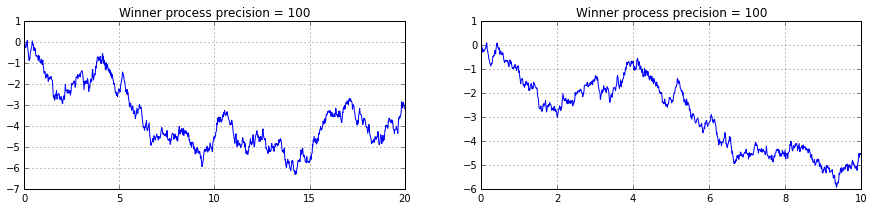

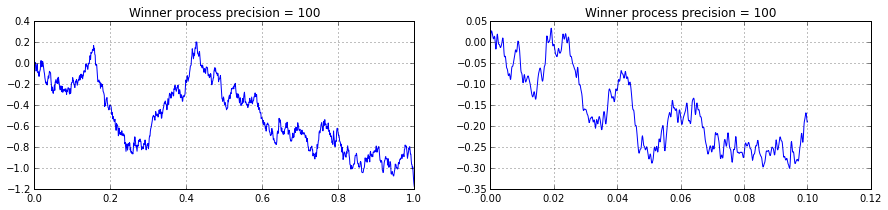

In [27]:
win_proc = WinerProccess()
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 20, num=1000), win_proc[np.linspace(0, 20, num=1000)])
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 10, num=1000), win_proc[np.linspace(0, 10, num=1000)])
plt.grid()
plt.show()
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 1, num=1000), win_proc[np.linspace(0, 1, num=1000)])
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 0.1, num=1000), win_proc[np.linspace(0, 0.1, num=1000)])
plt.grid()
plt.show()

Легко заметить, что вид графиков остался таким же при изменении масштаба. Уменьшим точность до 100.

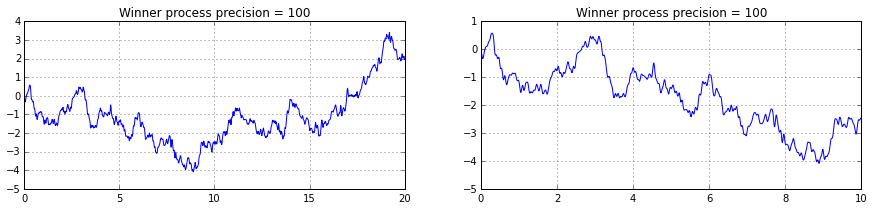

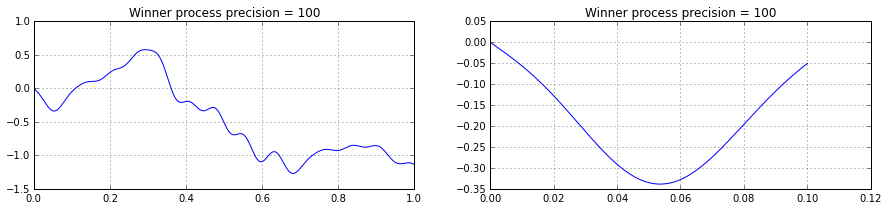

In [26]:
win_proc = WinerProccess(precision=100)
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 20, num=1000), win_proc[np.linspace(0, 20, num=1000)])
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 10, num=1000), win_proc[np.linspace(0, 10, num=1000)])
plt.grid()
plt.show()
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 1, num=1000), win_proc[np.linspace(0, 1, num=1000)])
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Winner process precision = 100")
plt.plot(np.linspace(0, 0.1, num=1000), win_proc[np.linspace(0, 0.1, num=1000)])
plt.grid()
plt.show()

При точнсти 100 с уменьшением масштаба траектория процесса получается все более гладкой. Траектория процесса диффернцируема при фиксированном k.

## Часть 2

Напишем класс для процесса в модели Миллера-Орра.

In [9]:
def generate_unif(a, b):
    return (b - a) * rand() + a

In [40]:
class MillerOrrModel:
    def __init__(self, A, B, W):
        self.a = A
        self.b = B
        self.win_proc = W
        self.y_min = 1.
        self.y_med = 5.
        self.y_max = 10.
        self.signs = [0.5,0.7,0.7,0.5,0.2,1]
        self.credits = []
        self.lambda_exp = 1.
        self.time_of_changes = 0
        self.T = 2
        
        
    def _calc_y_t(self, t):
        return self.a + self.b * t + self.win_proc[[t]][0]
    
    def _check_repayment(self, time):
        flag = False
        if len(self.credits) > 0 and time >= self.credits[0]:
            self.a = self.a - (self.y_med - self.y_min)
            self.credits = self.credits[1:]
            flag = True
            
        return flag
   
    def _sell_shares(self):
        delta_a = sps.norm.rvs(loc=self.y_med - self.y_min, scale=self.signs[1], size=1)[0]
        self.a = self.a + delta_a
        delta_b = sps.norm.rvs(loc=1, scale=self.signs[2], size=1)[0]
        self.b = self.b + delta_b

    def _take_the_credit(self, time):
        self.credits.append(time + self.T)
        self.a = self.a + self.y_med - self.y_min
        delta_b = sps.norm.rvs(loc=1, scale=self.signs[3], size=1)[0]
        self.b = self.b + delta_b
        
    def _buy_shares(self):
        delta_a = sps.laplace.rvs(loc=(self.y_med - self.y_max)/2., scale=self.signs[4], size=1)[0]
        self.a = self.a + delta_a
        delta_b = sps.norm.rvs(loc=-1, scale=self.signs[5], size=1)[0]
        self.b = self.b + delta_b
        #print "buying delta a ", delta_a, " delta b ", delta_b
    
    def _simulate_external_circumstances(self):
        self.time_of_changes = self.time_of_changes + sps.expon.rvs(scale=1./self.lambda_exp, size=1)[0]  
        current_money = self._calc_y_t(self.time_of_changes)               
        delta_b = sps.norm.rvs(scale=self.signs[0], size=1)[0]
        self.b = self.b + delta_b
        self.a = self.a - delta_b * self.time_of_changes
    
    def __getitem__(self, times):
        answer = []    
        sell_shares_times = []
        credits_times = []
        buying_shares_times = []  
        repayment_credits = []
        
        for time in times:
            while time > self.time_of_changes:
                self._simulate_external_circumstances()           
            
            if self._check_repayment(time):
                repayment_credits.append(time)
                
            y = self._calc_y_t(time)
            actions_counter = 0
            
            while (y < self.y_min or y > self.y_max) and actions_counter < 10:    
                if y < self.y_min:
                    if rand() < 0.5:
                        sell_shares_times.append(time)
                        self._sell_shares()
                    else:
                        credits_times.append(time)
                        self._take_the_credit(time)
                elif y > self.y_max:
                    buying_shares_times.append(time)
                    self._buy_shares()      
                else:
                    print "error time = ", time
                    break              
                y = self._calc_y_t(time)
                actions_counter = actions_counter + 1
                
            answer.append(y) 
    
        return [answer, sell_shares_times, credits_times, buying_shares_times, repayment_credits]

Подберем параметры и сгенерируем несколько графиков этого процесса.

In [51]:
def create_process():
    max_t = 10.
    precision = 1000.
    A = generate_unif(min(3, max_t/2.), max_t/2.)
    B = generate_unif(-max_t/3., max_t/3.)
    W = WinerProccess()
    model = MillerOrrModel(A, B, W)
    plt.figure(figsize=(18, 6))
    plt.xlim((0, max_t + 2))
    plt.xlabel('time')
    plt.ylim((model.y_min -1, model.y_max + 1))
    plt.ylabel('money')
    plt.subplot(1, 1, 1)
    result = model[np.linspace(0, max_t, num=precision)]
    plt.plot(np.linspace(0, max_t, num=precision), result[0])
    plt.scatter(result[1], [result[0][int(i * precision / max_t)] for i in result[1]], color='black', s=40)  # selling shares
    plt.scatter(result[2], [result[0][int(i * precision / max_t)] for i in result[2]], color='orange', s=40)  # credit
    plt.scatter(result[3], [result[0][int(i * precision / max_t)] for i in result[3]], color='magenta', s=40)  # buying shares
    plt.scatter(result[4], [result[0][int(i * precision / max_t)] for i in result[4]], color='brown', s=40)  # repaying credits
    plt.plot([0,max_t], [model.y_min, model.y_min], color='red')
    plt.plot([0,max_t], [model.y_med, model.y_med], color='g')
    plt.plot([0,max_t], [model.y_max, model.y_max], color='red')
    plt.legend(['process', 'max', 'medium','min','selling shares', 'taking credit', 'buying shares', 'repaying credits'])
    plt.grid()
    plt.show()

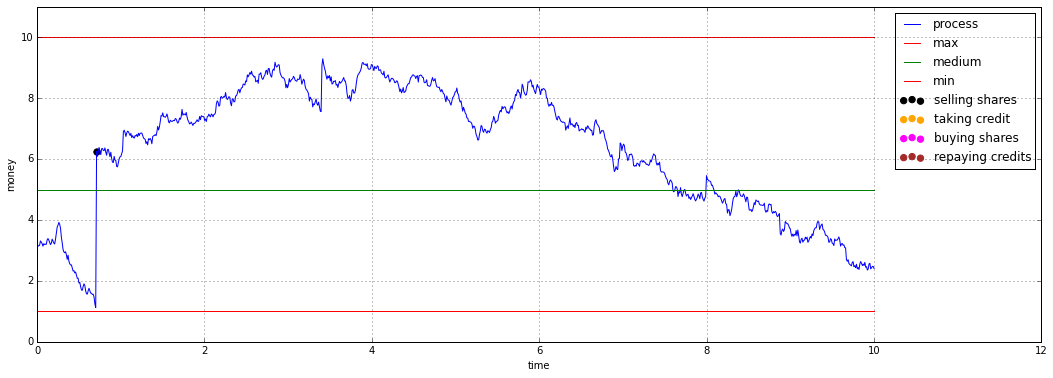

In [52]:
create_process()

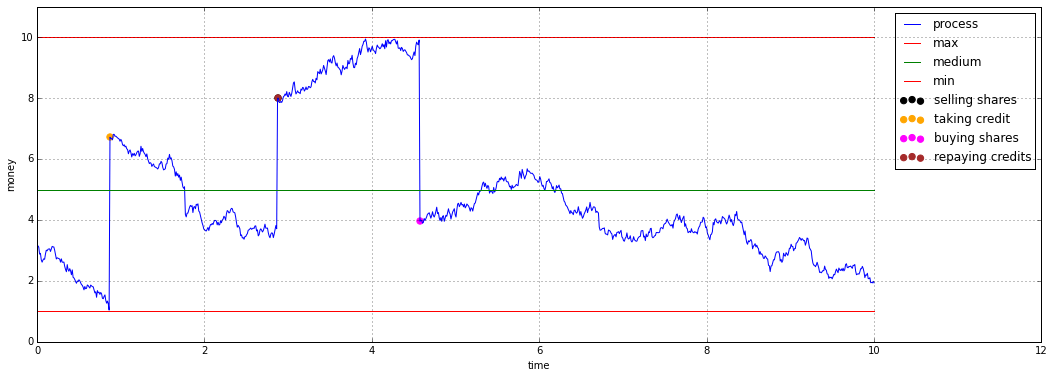

In [54]:
create_process()

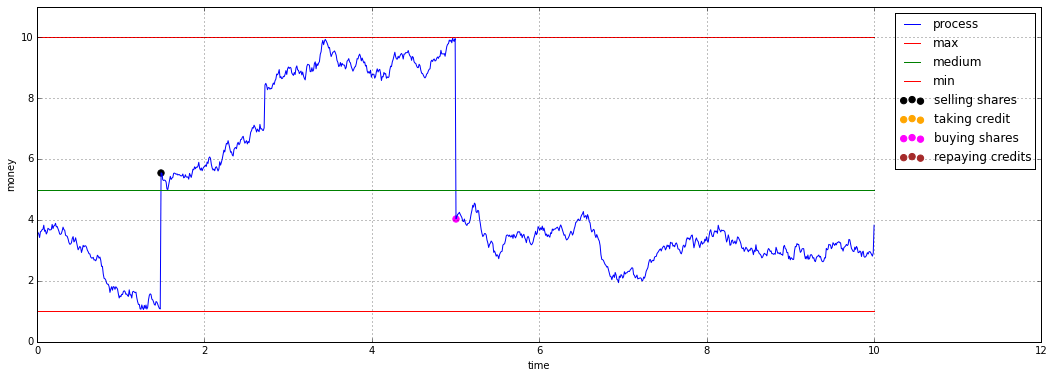

In [57]:
create_process()

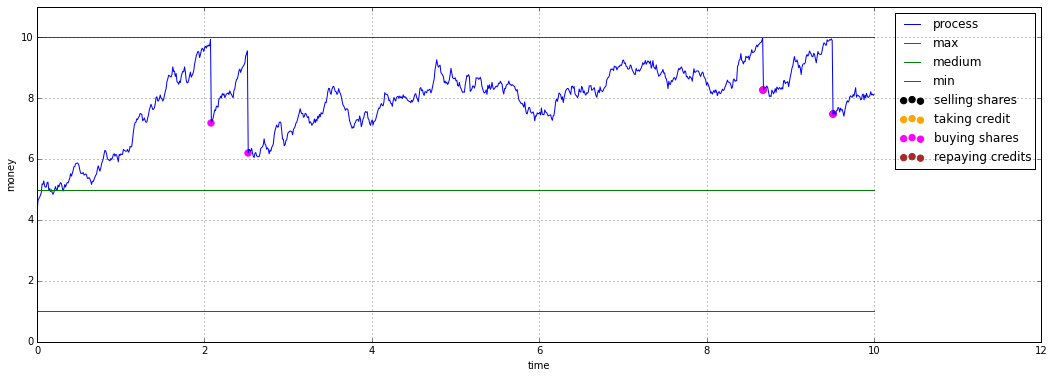

In [60]:
create_process()

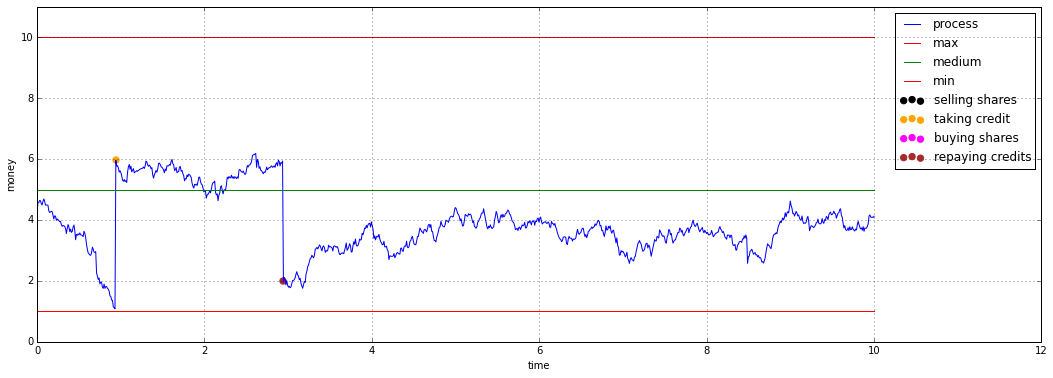

In [61]:
create_process()

На графиках отобразились все возможные действия компании: продажа и покупка акций, заем и выплата кредита.